# Estimating Pi

The following example should highlight, how one can convert most Python classes that take arguments into a ZnTrack stage.
Here we take on an example to Estimate the value Pi.
The original notebook can be found here https://gist.github.com/SamTov/907aebbc6c36a242e15e3745a91989eb .
There were only a few changes made:

    1. convert parameters to `zn.params()`
    2. convert results to `zn.outs()`
    3. modify the `__init__` method for the adding the parameters to the class
    4. Add a `run` method that does the heavy lifting for us and runs the expensive computation

That's it - now we can inherit from `zntrack.Node` and we can even stay inside the Jupyter notebook.

In [1]:
from zntrack import ZnTrackProject, config

config.nb_name = "estimate_pi_with_mc.ipynb"

In [2]:
from zntrack.utils import cwd_temp_dir

temp_dir = cwd_temp_dir()

In [3]:
project = ZnTrackProject()
project.create_dvc_repository()

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from zntrack import Node, zn

In [5]:
class MCPi(Node):
    """
    A class to study Monte Carlo sampling as applied to
    the computation of Pi.

    Attributes
    ----------
    coordinates : np.ndarray
            Coordinates of points plotted.
    n_circle_points : int
            Number of points in the circle
    n_points : int
            Total number of points.
    """

    coordinates = zn.outs()
    n_circle_points = zn.outs()
    n_points = zn.params()

    def __init__(self, n_points=None, **kwargs):
        super().__init__(**kwargs)
        self.n_points = n_points

    def run(self):
        """
        Draw N points from a normal distribution.

        N : int
                Number of points to draw.
        """
        self.coordinates = np.random.random(size=(self.n_points, 2))
        self._circle_points()  # compute the number of points in the circle.

    def _circle_points(self):
        """
        Compute the number of points in the circle.
        """
        radial_values = np.linalg.norm(self.coordinates, axis=1)
        self.n_circle_points = len(list(filter(lambda x: x <= 1, radial_values)))

    def plot_image(self, axs=None):
        """
        Plot the circle, square, and points.

        Parameters
        ----------
        axs : mpl.axis
                An axis object to plot to if desired.
        """
        circle = plt.Circle((0, 0), 1, fill=False)
        square = patches.Rectangle((0, 0), 1, 1, fill=False)
        if axs is None:
            ax = plt.gca()
        else:
            ax = axs
        ax.set_xlim(-1.3, 1.3)
        ax.set_ylim(-1.3, 1.3)
        ax.spines.left.set_position("zero")
        ax.spines.right.set_color("none")
        ax.spines.bottom.set_position("zero")
        ax.spines.top.set_color("none")
        ax.xaxis.set_ticks_position("bottom")
        ax.yaxis.set_ticks_position("left")
        ax.add_patch(circle)
        ax.add_patch(square)
        ax.set_aspect("equal")
        plt.show()

    def plot_sampling(self, axs=None, show: bool = False):
        """
        Plot the result of the sampling.

        Parameters
        ----------
        axs : mpl.axis
                An axis object to plot to if desired.
        """
        coordinates = np.array(self.coordinates)
        circle = plt.Circle((0, 0), 1, fill=False, linewidth=3, edgecolor="k", zorder=10)
        square = patches.Rectangle(
            (0, 0), 1, 1, fill=False, linewidth=3, edgecolor="k", zorder=10
        )
        if axs is None:
            ax = plt.gca()
        else:
            ax = axs
        ax.set_xlim(-0.0, 1.0)
        ax.set_ylim(-0.0, 1.0)
        ax.spines.left.set_position("zero")
        ax.spines.right.set_color("none")
        ax.spines.bottom.set_position("zero")
        ax.spines.top.set_color("none")
        ax.xaxis.set_ticks_position("bottom")
        ax.yaxis.set_ticks_position("left")
        ax.plot(coordinates[:, 0], coordinates[:, 1], ".")
        inner_points = np.array(
            list(filter(lambda x: np.linalg.norm(x) <= 1, coordinates))
        )
        ax.plot(inner_points[:, 0], inner_points[:, 1], "r.")
        ax.add_patch(circle)
        ax.add_patch(square)
        ax.set_title(
            f"N: {self.n_points} ; $\pi$ = {4 * self.n_circle_points / self.n_points}"
        )
        ax.set_aspect("equal")

        if show:
            plt.show()

Now let us define pi estimates with different numbers of points and run them all.

In [6]:
MCPi(n_points=50000).write_graph()

2022-02-22 13:32:07,768 (WARNING): Jupyter support is an experimental feature! Please save your notebook before running this command!
Submit issues to https://github.com/zincware/ZnTrack.
2022-02-22 13:32:11,170 (WARNING): Running DVC command: 'dvc run -n MCPi ...'


In [7]:
MCPi(n_points=10000).write_graph()
project.name = "n=10000"
project.queue()

MCPi(n_points=1000).write_graph()
project.name = "n=1000"
project.queue()

MCPi(n_points=100).write_graph()
project.name = "n=100"
project.run()

2022-02-22 13:32:17,486 (WARNING): Running DVC command: 'dvc run -n MCPi ...'
2022-02-22 13:32:20,109 (WARNING): Running DVC command: 'dvc exp run --name ...'
2022-02-22 13:32:25,717 (WARNING): Running DVC command: 'dvc run -n MCPi ...'
2022-02-22 13:32:28,576 (WARNING): Running DVC command: 'dvc exp run --name ...'
2022-02-22 13:32:34,429 (WARNING): Running DVC command: 'dvc run -n MCPi ...'
2022-02-22 13:32:37,110 (WARNING): Running DVC command: 'dvc exp run --name ...'
2022-02-22 13:32:39,593 (WARNING): Running DVC command: 'dvc exp run --run-all'
Changes for experiment 'n=100' have been applied to your current workspace.


We can now see our experiments and the respective hash values:


Let us load them and plot them after each other. Because all the calculations where already performed, this is simply loading the correct result files.

Changes for experiment 'n=10000' have been applied to your current workspace.


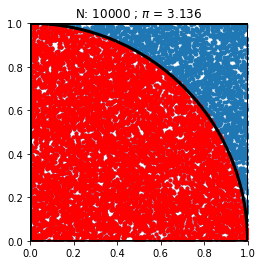

Changes for experiment 'n=1000' have been applied to your current workspace.


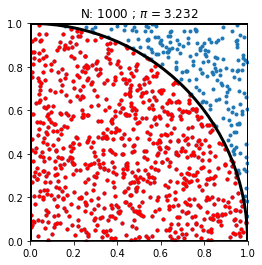

Changes for experiment 'n=100' have been applied to your current workspace.


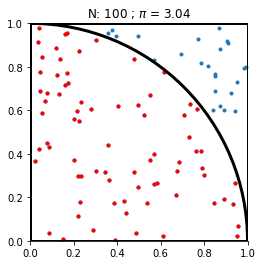

In [8]:
project.load("n=10000")
MCPi.load().plot_sampling(show=True)
project.load("n=1000")
MCPi.load().plot_sampling(show=True)
project.load("n=100")
MCPi.load().plot_sampling(show=True)

In [9]:
MCPi.load().coordinates

array([[0.36522311, 0.27782089],
       [0.07680399, 0.45201514],
       [0.21572141, 0.59858927],
       [0.76762623, 0.60391583],
       [0.1518567 , 0.00687583],
       [0.44109677, 0.12888342],
       [0.78771576, 0.41425928],
       [0.68518212, 0.36443915],
       [0.84097029, 0.6036064 ],
       [0.30414312, 0.92169279],
       [0.28093336, 0.60753074],
       [0.03946694, 0.42304863],
       [0.49542394, 0.62345125],
       [0.17013706, 0.77096243],
       [0.38675165, 0.17420516],
       [0.11816306, 0.88455443],
       [0.16234308, 0.95124131],
       [0.0856473 , 0.43313186],
       [0.1310151 , 0.67721904],
       [0.70798137, 0.57974781],
       [0.22196449, 0.11215714],
       [0.22037193, 0.29799619],
       [0.06835654, 0.64471537],
       [0.03568006, 0.9130928 ],
       [0.84653501, 0.1732858 ],
       [0.04343136, 0.68720937],
       [0.87467318, 0.88378947],
       [0.77143299, 0.92887402],
       [0.37530866, 0.96795907],
       [0.84934535, 0.68703284],
       [0.

In [10]:
temp_dir.cleanup()